In [1]:
import os
import importlib.util

import matplotlib
# matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

import numpy as np
import h5py
import tensorflow as tf
import pickle

from alad_mod.alad import ALAD
from evaluation.histogram_builder import *
from data.hlf_preprocessing import load

In [2]:
result_path = '/home/oliverkn/pro/alad_6021/2_l16'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))

loading alad


W1116 17:00:43.858405 140443948517184 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1116 17:00:43.900136 140443948517184 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1116 17:00:43.903576 140443948517184 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1116 17:00:43.904588 140443948517184 deprecation.py:323] From /home/oliverkn/pro/alad_6021/2_l16/config.py:81: dense (from tens

In [3]:
lum = 4429

W_proc_list = ['w1jets', 'w2jets', 'w3jets']
DY_proc_list = ['dy1jets', 'dy2jets', 'dy3jets', 'dy4jets']
ttbar_proc_list = ['ttbar']
data_proc_list = ['data']
b_proc_list = W_proc_list + DY_proc_list
bs_proc_list = b_proc_list + ttbar_proc_list
proc_list = bs_proc_list + data_proc_list

sets = {}
sets['dy1jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7719/data.hdf5', 'xsec':561, 'K':1.23}
sets['dy2jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7721/data.hdf5', 'xsec':181, 'K':1.23}
sets['dy3jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7722/data.hdf5', 'xsec':51, 'K':1.23}
sets['dy4jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7723/data.hdf5', 'xsec':15, 'K':1.23}

sets['w1jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9863/data.hdf5', 'xsec':4480, 'K':1.23}
sets['w2jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9864/data.hdf5', 'xsec':1435, 'K':1.23}
sets['w3jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9865/data.hdf5', 'xsec':304, 'K':1.23}

# sets['dy1jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7730/data.hdf5', 'xsec':1141, 'K':1}
# sets['dy2jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7723/data.hdf5', 'xsec':0, 'K':1.23}
# sets['dy3jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7723/data.hdf5', 'xsec':0, 'K':1.23}
# sets['dy4jets'] = {'file': '/home/oliverkn/pro/opendata_v2/7723/data.hdf5', 'xsec':0, 'K':1.23}
# 
# sets['w1jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9938/data.hdf5', 'xsec':5090, 'K':1}
# sets['w2jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9940/data.hdf5', 'xsec':7110, 'K':1}
# sets['w3jets'] = {'file': '/home/oliverkn/pro/opendata_v2/9865/data.hdf5', 'xsec':0, 'K':1}

sets['ttbar'] = {'file': '/home/oliverkn/pro/opendata_v2/9588/data.hdf5', 'xsec':164, 'K':1.66}

sets['data'] = {'file': '/home/oliverkn/pro/opendata_v2/6021/data.hdf5', 'xsec':1, 'K':1}

In [4]:
data_dict = {}

def pre_select(x):
    filter_iso = x[:,7] + x[:,8] + x[:,9] < 0.1
    filter_eta = np.abs(x[:,5]) < 1.4
    # filter_eta2 = np.logical_or(np.abs(x[:,5]) < 1.44, np.abs(x[:,5]) > 1.56)
    filter_njets = x[:,2] > 1
    # filter_idx = filter_njets * filter_eta * filter_iso #* filter_eta2
    filter_idx = filter_iso * filter_eta * filter_njets
    
    return x[filter_idx]

for key, set in sets.items():
    print('-----------------loading %s-----------------' % key)

    file = set['file']
    hdf5_file = h5py.File(file, 'r')
    
    data = hdf5_file['data']
    n_tot = hdf5_file['n_tot'][()]
    n_tup = data.shape[0]
    
    if key == 'data':
        x = data[()]
    else:
        n_tot_target = lum * set['xsec'] * set['K']
        n_tup_target = int(n_tot_target/n_tot * n_tup)
        
        print('n_tup        = %d' % n_tup)
        print('n_tup_target = %d' % n_tup_target)
        if(n_tup < n_tup_target):
            print('***********WARNING***********: not enough samples available')
            
        x = data[0:n_tup_target]
    
    # run preselection
    x = pre_select(x)
    
    sets[key]['x_pre'] = x

-----------------loading dy1jets-----------------
n_tup        = 907244
n_tup_target = 876304
-----------------loading dy2jets-----------------
n_tup        = 308661
n_tup_target = 295463
-----------------loading dy3jets-----------------
n_tup        = 647464
n_tup_target = 85620
-----------------loading dy4jets-----------------
n_tup        = 521818
n_tup_target = 25944
-----------------loading w1jets-----------------
n_tup        = 6009999
n_tup_target = 4924572
-----------------loading w2jets-----------------
n_tup        = 1667510
n_tup_target = 1643696
-----------------loading w3jets-----------------
n_tup        = 361756
n_tup_target = 353785
-----------------loading ttbar-----------------
n_tup        = 4148758
n_tup_target = 208766
-----------------loading data-----------------


In [5]:
for key, set in sets.items():
    print('%s: %s' % (key, set['x_pre'].shape))

dy1jets: (403770, 23)
dy2jets: (148204, 23)
dy3jets: (44224, 23)
dy4jets: (13283, 23)
w1jets: (1682588, 23)
w2jets: (705603, 23)
w3jets: (167926, 23)
ttbar: (128620, 23)
data: (7711955, 23)


In [6]:
# ano_score, ano_ppm, ano_ppm_pos, pos

cont_bins = 40
hist_settings = {}
hist_settings['HT'] = {'symbol': '$H_T$ [GeV]', 'range': (0, 3000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['mass_jet'] = {'symbol': '$M_J$ [GeV]', 'range': (0, 3000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_jet'] = {'symbol': '$N_J$', 'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['n_bjet'] = {'symbol': '$N_b$', 'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['lep_pt'] = {'range': (20, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['lep_eta'] = {'range': (-2.5, 2.5), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
hist_settings['lep_charge'] = {'range': (-1, 1), 'yscale': 'linear', 'int': True}
hist_settings['lep_iso_ch'] = {'range': (0, 0.1), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['lep_iso_neu'] = {'range': (0, 0.1), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['lep_iso_gamma'] = {'range': (0, 0.1), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['MET'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['METo'] = {'range': (-100, 100), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
hist_settings['METp'] = {'range': (-100, 100), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
hist_settings['MT'] = {'range': (0, 200), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_mu'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['pt_mu'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['mass_mu'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_ele'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['pt_ele'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['mass_ele'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
hist_settings['n_neu'] = {'range': (0, 400), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['n_ch'] = {'range': (0, 1000), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings['n_photon'] = {'range': (0, 1000), 'yscale': 'linear', 'int': True, 'bin_size': 1}

def build_hists(x, selection_functions):
    hist_builder_arr = [HistogramBuilder(hist_settings) for f in selection_functions]
    
    x_f = x
    for i, f in enumerate(selection_functions):
        x_f = f(x_f)
        hist_builder_arr[i].add_data(x_f)
    
    # # perform upscaling
    # upscale_factor = x.shape[0] / n
    # print('processed/available: %d/%d = %f'%(n_events, x.shape[0], n/x.shape[0]))
    # hists = [scale_hists(builder.get_histogram_data(), upscale_factor) for builder in hist_builder_arr]
    
    return [builder.get_histogram_data() for builder in hist_builder_arr]

hist_cut_proc_dict = {}

def build_all_hists(cut_functions, cut_names, proc_list=None):
    if proc_list is None:
        proc_list = sets.keys()
    
    for proc in proc_list:
        set = sets[proc]
        print('building hist for %s' % proc)
    
        # build hists
        hists = build_hists(set['x_pre'], cut_functions)
        
        # add hists to dict
        cut_name = 'pre'
        for i in range(len(hists)):
            cut_name += '-' + cut_names[i]
            
            if cut_name not in hist_cut_proc_dict:
                hist_cut_proc_dict[cut_name] = {}
                
            hist_cut_proc_dict[cut_name][proc] = hists[i]
        

In [7]:
def id_select(x):
    return x

build_all_hists([id_select], [''])
print('done')

building hist for dy1jets
building hist for dy2jets
building hist for dy3jets
building hist for dy4jets
building hist for w1jets
building hist for w2jets
building hist for w3jets
building hist for ttbar
building hist for data
done


In [8]:
def anomaly_score_select(x, thres=30, score_type='l1'):
    x_transformed = preprocessor.transform(x)
    scores = ad.get_anomaly_scores(x_transformed, type=score_type)  
    anomaly_idx = scores > thres
    return x[anomaly_idx]


build_all_hists([anomaly_score_select], ['anoscore'])

building hist for dy1jets
building hist for dy2jets
building hist for dy3jets
building hist for dy4jets
building hist for w1jets
building hist for w2jets
building hist for w3jets
building hist for ttbar
building hist for data


In [9]:
sum_n_pre = 0
sum_n_ano = 0
for proc in bs_proc_list:
    sum_n_pre += hist_cut_proc_dict['pre-'][proc]['HT'].n
    sum_n_ano += hist_cut_proc_dict['pre-anoscore'][proc]['HT'].n
    
for proc in bs_proc_list:
    n = hist_cut_proc_dict['pre-'][proc]['HT'].n
    print('%s: %d (%f)'%(proc, n, n/sum_n_pre))

print('--------------------------------------')
print('n_tup (mc):   %d' % sum_n_pre)
print('n_tup (data): %d' % hist_cut_proc_dict['pre-']['data']['HT'].n)

w1jets: 1682588 (0.510770)
w2jets: 705603 (0.214194)
w3jets: 167926 (0.050976)
dy1jets: 403770 (0.122569)
dy2jets: 148204 (0.044989)
dy3jets: 44224 (0.013425)
dy4jets: 13283 (0.004032)
ttbar: 128620 (0.039044)
--------------------------------------
n_tup (mc):   3294218
n_tup (data): 7711955


In [12]:
sum_n_pre = 0
sum_n_ano = 0
for proc in bs_proc_list:
    sum_n_pre += hist_cut_proc_dict['pre-'][proc]['HT'].n
    sum_n_ano += hist_cut_proc_dict['pre-anoscore'][proc]['HT'].n
  
q_target = sum_n_ano / sum_n_pre
print('Target ppm: %d' % (q_target * 1e6))

def anomaly_q_select(x, q=q_target, score_type='l1'):
    x_transformed = preprocessor.transform(x)
    scores = ad.get_anomaly_scores(x_transformed, type=score_type)  
    thres = np.quantile(scores, 1 - q)
    anomaly_idx = scores > thres
    return x[anomaly_idx]

build_all_hists([anomaly_q_select], ['ano_q_bs'])
print('done')

Target ppm: 377
building hist for dy1jets
building hist for dy2jets
building hist for dy3jets
building hist for dy4jets
building hist for w1jets
building hist for w2jets
building hist for w3jets
building hist for ttbar
building hist for data
done


In [16]:
for cut, hist_proc_dict in hist_cut_proc_dict.items():  
    # sum W
    hist_W = sum_hists([hist_proc_dict[proc] for proc in W_proc_list])
    hist_proc_dict['W'] = hist_W
    
    # sum DY
    hist_DY = sum_hists([hist_proc_dict[proc] for proc in DY_proc_list])
    hist_proc_dict['DY'] = hist_DY
    
    #sum background
    hist_b = sum_hists([hist_proc_dict[proc] for proc in b_proc_list])
    hist_proc_dict['b'] = hist_b
    
    #sum background + signal
    hist_bs = sum_hists([hist_proc_dict[proc] for proc in bs_proc_list])
    hist_proc_dict['bs'] = hist_bs

# print event numbers
for cut, hist_proc_dict in hist_cut_proc_dict.items():  
    print('---------------------%s---------------------' % cut)
    for proc in ['W', 'DY', 'ttbar', 'b', 'bs', 'data']:
        hist_proc = hist_proc_dict[proc]
        n = hist_proc['HT'].n
        print('%s total events:\t %d' %(proc, n))

---------------------pre----------------------
W total events:	 2556117
DY total events:	 609481
ttbar total events:	 128620
b total events:	 3165598
bs total events:	 3294218
data total events:	 7711955
---------------------pre-anoscore---------------------
W total events:	 477
DY total events:	 197
ttbar total events:	 569
b total events:	 674
bs total events:	 1243
data total events:	 2794
---------------------pre-ano_q_bs---------------------
W total events:	 966
DY total events:	 232
ttbar total events:	 49
b total events:	 1198
bs total events:	 1247
data total events:	 2910


In [17]:
# amp = trans_data / trans_mc = (n_data_a / n_data) / (n_mc_a / n_mc)

hist_mc_b = hist_cut_proc_dict['pre-ano_q_bs']['b'] # background (W, DY)
hist_mc_bs = hist_cut_proc_dict['pre-ano_q_bs']['bs'] # background + ttbar

def compute_amp(hist_pre, hist_ano):
    hist_amp = {}

    for key in hist_pre.keys():
        hist_amp[key] = Histogram(hist_pre[key].bin_edges)
        hist_amp[key].bin_content = hist_ano[key].bin_content / (hist_pre[key].bin_content+1)
    
    return hist_amp

# hist_amp_dict[proc]
hist_amp_dict = {}
hist_amp_dict['b'] = compute_amp(hist_cut_proc_dict['pre-']['b'], hist_cut_proc_dict['pre-anoscore']['b'])
hist_amp_dict['bs'] = compute_amp(hist_cut_proc_dict['pre-']['bs'], hist_cut_proc_dict['pre-anoscore']['bs'])
hist_amp_dict['data'] = compute_amp(hist_cut_proc_dict['pre-']['data'], hist_cut_proc_dict['pre-ano_q_bs']['data'])



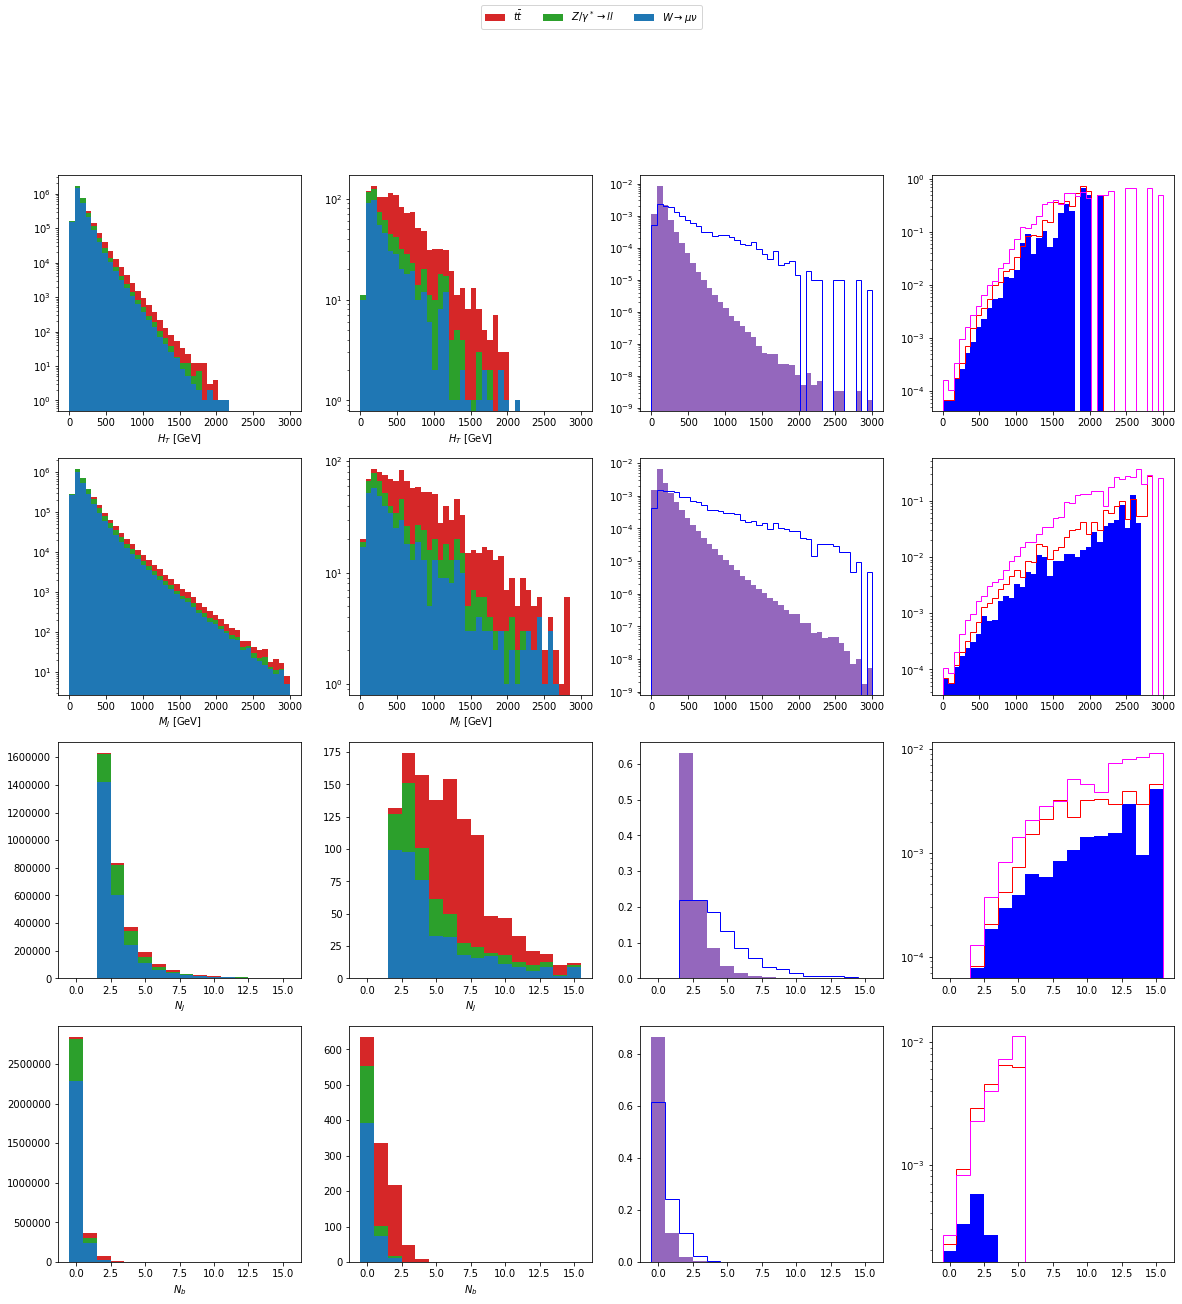

In [18]:
feature_list = ['HT', 'mass_jet', 'n_jet', 'n_bjet']
background_plot_list = ['W', 'DY', 'ttbar']

plot_size = 5

color_dict = {}
color_dict['W']='tab:blue'
color_dict['DY']='tab:green'
color_dict['ttbar']='tab:red'
color_dict['data']='tab:purple'

label_dict = {}
label_dict['W'] = r'$W \rightarrow \mu\nu$'
label_dict['DY'] = r'$Z/\gamma^* \rightarrow ll$'
label_dict['ttbar'] = r'$t\bar{t}$'

all_lin = False

n_features = len(feature_list)
fig, ax_arr = plt.subplots(n_features, 4, figsize=(4 * plot_size, n_features * plot_size))

for row, feature in enumerate(feature_list):
    f_setting = hist_settings[feature]
    
    # col 0, 1
    for col, cut in enumerate(['pre-', 'pre-anoscore']):
        ax = ax_arr[row, col]
    
        # plot background stacked
        x_list = []
        bin_edges = None
        weights_list = []
        color_list = []
        label_list = []
        
        for proc in background_plot_list:
            hist = hist_cut_proc_dict[cut][proc]
            bin_edges = hist[feature].bin_edges
            x_list.append(hist[feature].bin_edges[:-1])
            weights_list.append(hist[feature].bin_content)
            color_list.append(color_dict[proc])
            label_list.append(label_dict[proc])
            
        ax.hist(x_list, bin_edges, weights=weights_list, 
                stacked=True, histtype='stepfilled', color=color_list, label=label_list)
        
        # axis settings
        if all_lin is False:
            ax.set_yscale(f_setting['yscale'])
            
        ax.set_xlabel(f_setting['symbol'])

    # col 2
    ax = ax_arr[row, 2]
    
    # plot data
    hist_data_f = hist_cut_proc_dict['pre-']['data'][feature]
    bin_edges = hist_data_f.bin_edges
    bin_content = hist_data_f.bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights=bin_content, histtype='stepfilled', density=True,color=color_dict['data'], label='data')
    
    # plot data anomalous
    hist_data_f = hist_cut_proc_dict['pre-anoscore']['data'][feature]
    bin_edges = hist_data_f.bin_edges
    bin_content = hist_data_f.bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights=bin_content, histtype='step', color='b', label='data a', density=True)

    # axis settings
    if all_lin is False:
        ax.set_yscale(f_setting['yscale'])

# fix ppm
# uncertainty (opt)

# plot ADSE
for row, feature in enumerate(feature_list):
    ax = ax_arr[row, 3]
    f_setting = hist_settings[feature]
    
    bin_edges = hist_amp_dict['b'][feature].bin_edges
    bin_content = hist_amp_dict['b'][feature].bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='stepfilled',# density=True,
            label='background', color='blue')

    bin_edges = hist_amp_dict['bs'][feature].bin_edges
    bin_content = hist_amp_dict['bs'][feature].bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='step',# density=True,
            label='W+DY+tt', color='red')
    
    bin_edges = hist_amp_dict['data'][feature].bin_edges
    bin_content = hist_amp_dict['data'][feature].bin_content
    ax.hist(bin_edges[:-1], bin_edges, weights = bin_content, histtype='step',# density=True,
            label='W+DY+tt', color='magenta')

    # bin_edges = hist_amp_dict['data'][feature].bin_edges
    # bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
    # bin_content = hist_amp_dict['data'][feature].bin_content
    # ax.plot(bin_centers, bin_content, 'bo', label='data')
    
    ax.set_yscale('log')

handles, labels = ax_arr[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=4)
# fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#         mode="expand", borderaxespad=0.)


plt.savefig('figures/adse.pdf')
plt.show()